# Comparison to BERT

Here, we compare `vhash` to `BERT` for a text-classificaiton task.

To use this notebook, you must obtain the Kaggle dataset [Coronavirus Tweets NLP - Text Classification](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification), and place the files in the `stats` folder.

In [1]:
# operate in project root directory

from os import chdir
import sys

# set path to allow module import
project_root = '/home/mike/vhash'
if project_root not in sys.path:
    sys.path.append(project_root)

# operate in project root directory
chdir(project_root)

In [2]:
# create train / test enum and model enum
from enum import IntEnum


class Set(IntEnum):
    """Easy train/test referencing"""
    TRAIN = 0
    TEST = 1


class Model(IntEnum):
    VHASH = 0
    BERT = 1

In [3]:
# load in data
from pandas import read_csv


df = [
    read_csv(f'stats/Corona_NLP_{file}.csv', encoding='latin-1')
    for file in ['train', 'test']
]

In [4]:
# show training data
df[Set.TRAIN].head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [5]:
# show testing data
df[Set.TEST].head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [6]:
# extract text and numerize labels
from numpy import array

# define label values
label_values = {
    'Extremely Negative': -2,
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1,
    'Extremely Positive': 2,
}

# get text
text = [
    d['OriginalTweet'].to_numpy()
    for d in df
]

# get labels as integers
labels = [
    array([
        label_values[y]
        for y in d['Sentiment']
    ])
    for d in df
]

In [7]:
# encode text
from sentence_transformers import SentenceTransformer

from vhash import VHash


# train vhash model
vhash = VHash().fit(text[Set.TRAIN], labels[Set.TRAIN])

# initialize bert encoder
bert = SentenceTransformer('all-MiniLM-L6-v2')

# encode text with vhash and bert
X = [
    [
        vhash.transform(t),
        bert.encode(t),
    ]
    for t in text
]

In [8]:
# train ML models, predict classes
from sklearn.linear_model import LinearRegression


regressor = [
    LinearRegression().fit(
        X[Set.TRAIN][model],
        labels[Set.TRAIN],
    )
    for model in Model
]
pred = [
    regressor[model].predict(X[Set.TEST][model])
    for model in Model
]

In [9]:
# get metrics
from IPython.display import display
from lifelines.utils import concordance_index
from numpy import corrcoef
from pandas import DataFrame
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score


metrics = DataFrame(
    {
        'MAE': [f'{mae(labels[Set.TEST], pred[model]):.2f}' for model in Model],
        'MSE': [f'{mse(labels[Set.TEST], pred[model]):.2f}' for model in Model],
        'R2': [f'{r2_score(labels[Set.TEST], pred[model]):.2f}' for model in Model],
        'CC': [f'{corrcoef(labels[Set.TEST], pred[model])[0, 1]:.2f}' for model in Model],
        'CI': [f'{concordance_index(labels[Set.TEST], pred[model]):.2f}' for model in Model],
    },
    index=['vhash', 'sBERT'],
)
display(metrics)

,MAE,MSE,R2,CC,CI
vhash,0.68,0.79,0.56,0.75,0.84
sBERT,0.92,1.25,0.30,0.55,0.74


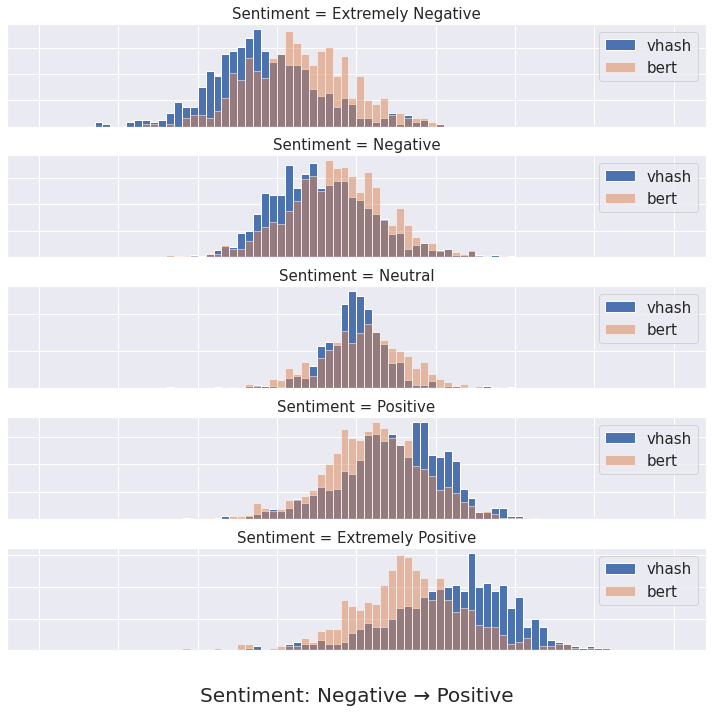

In [10]:
# plot results
from matplotlib import pyplot
from numpy import arange, array
import seaborn


# make pretty
seaborn.set_theme()

# make figure
fig, ax = pyplot.subplots(5, 1, figsize=(10, 10))

# plot points
for n, label in enumerate(range(-2, 3)):
    for model in Model:

        # plot histogram
        ax[n].hist(
            pred[model][labels[Set.TEST] == label],
            alpha=(.5 if model else 1),
            bins=arange(-4, 4.1, .1),
            density=True,
            label=str(model).rsplit('.')[-1].lower(),
        )

        # show legend
        ax[n].legend(fontsize=15)

        # turn off ticks
        ax[n].set_xticklabels([])
        ax[n].set_yticklabels([])

        # make title
        ax[n].set_title(
            'Sentiment = ' + list(label_values.keys())[n],
            fontsize=15,
        )

ax[-1].set_xlabel('\nSentiment: Negative → Positive', fontsize=20)

# show figure
fig.tight_layout()
pyplot.show()